# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Import libraries

In [55]:
import pandas as pd
import numpy as np
from scipy import stats

import psycopg2
import os
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as go 
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


### Get the data

In [56]:
# Connecting to the database
postgre_db = 'mid_term_project'
postgre_user = 'lhl_student'
postgre_password = 'lhl_student'
postgre_host = 'mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com'
postgre_port = '5432'

In [57]:
con = psycopg2.connect(database = postgre_db,
                       user= postgre_user, 
                       password= postgre_password, 
                       host= postgre_host, 
                       port= postgre_port)

In [58]:
def execute_read_query(connection, query, return_pandas=True):
    cursor = connection.cursor()
    result = None
    try:
        if return_pandas:
            result = pd.read_sql_query(query, connection)
        else:
            cursor.execute(query)
            result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

In [59]:
flight_query = """
                    SELECT * FROM flights
                    ORDER BY RANDOM()
                    LIMIT 500000;            
                   """
flight_data = execute_read_query(con,flight_query)
flight_data

/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-06-26,UA,UA_CODESHARE,UA,4697,AX,N11155,4697,13930,ORD,"Chicago, IL",11111,COU,"Columbia, MO",1940,1931.0,-9.0,22.0,1953.0,2043.0,6.0,2104,2049.0,-15.0,0.0,None,0.0,N,84.0,78.0,50.0,1.0,315.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,2019-09-11,DL,DL_CODESHARE,DL,6249,G7,N331CA,6249,13487,MSP,"Minneapolis, MN",10408,ATW,"Appleton, WI",1000,1148.0,108.0,15.0,1203.0,1248.0,3.0,1113,1251.0,98.0,0.0,None,0.0,N,73.0,63.0,45.0,1.0,236.0,0.0,0.0,0.0,0.0,98.0,None,NaN,NaN,None
2,2019-11-15,WN,WN,WN,591,WN,N8678E,591,11066,CMH,"Columbus, OH",11292,DEN,"Denver, CO",925,923.0,-2.0,11.0,934.0,1013.0,5.0,1040,1018.0,-22.0,0.0,None,0.0,N,195.0,175.0,159.0,1.0,1154.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
3,2019-11-22,AS,AS,AS,103,AS,N260AK,103,14747,SEA,"Seattle, WA",11630,FAI,"Fairbanks, AK",2330,2353.0,23.0,12.0,5.0,234.0,4.0,220,238.0,18.0,0.0,None,0.0,N,230.0,225.0,209.0,1.0,1533.0,0.0,0.0,0.0,0.0,18.0,None,NaN,NaN,None
4,2019-01-18,AA,AA,AA,2384,AA,N159AN,2384,13930,ORD,"Chicago, IL",10721,BOS,"Boston, MA",717,711.0,-6.0,11.0,722.0,1005.0,5.0,1031,1010.0,-21.0,0.0,None,0.0,N,134.0,119.0,103.0,1.0,867.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2018-01-30,DL,DL,DL,2612,DL,N344NW,2612,10397,ATL,"Atlanta, GA",11278,DCA,"Washington, DC",2215,2213.0,-2.0,10.0,2223.0,2343.0,3.0,2356,2346.0,-10.0,0.0,,0.0,N,101.0,93.0,80.0,1.0,547.0,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,None
499996,2019-12-26,DL,DL_CODESHARE,DL,4155,OO,N267SY,4155,14869,SLC,"Salt Lake City, UT",14570,RNO,"Reno, NV",855,839.0,-16.0,55.0,934.0,938.0,3.0,944,941.0,-3.0,0.0,None,0.0,N,109.0,122.0,64.0,1.0,422.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
499997,2018-03-22,AA,AA_CODESHARE,AA,2960,OO,N755SK,2960,10693,BNA,"Nashville, TN",13930,ORD,"Chicago, IL",1417,1414.0,-3.0,20.0,1434.0,1555.0,15.0,1608,1610.0,2.0,0.0,None,0.0,N,111.0,116.0,81.0,1.0,409.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
499998,2018-03-17,DL,DL_CODESHARE,DL,5433,EV,N676CA,5433,13367,MLI,"Moline, IL",10397,ATL,"Atlanta, GA",1733,1802.0,29.0,12.0,1814.0,2036.0,9.0,2028,2045.0,17.0,0.0,None,0.0,N,115.0,103.0,82.0,1.0,633.0,0.0,0.0,0.0,0.0,17.0,None,NaN,NaN,None


### Create a data frame

In [60]:
df_flight = pd.DataFrame(flight_data)


In [61]:
# Save the data as csv format
df_flight.to_csv('df_flights.csv')

In [62]:
df_flights = pd.read_csv('df_flights.csv', index_col = 0)

In [63]:
df_flights['fl_date'].min(), df_flights['fl_date'].max()

('2018-01-01', '2019-12-31')

In [64]:
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-06-26,UA,UA_CODESHARE,UA,4697,AX,N11155,4697,13930,ORD,"Chicago, IL",11111,COU,"Columbia, MO",1940,1931.0,-9.0,22.0,1953.0,2043.0,6.0,2104,2049.0,-15.0,0.0,NaN,0.0,N,84.0,78.0,50.0,1.0,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-09-11,DL,DL_CODESHARE,DL,6249,G7,N331CA,6249,13487,MSP,"Minneapolis, MN",10408,ATW,"Appleton, WI",1000,1148.0,108.0,15.0,1203.0,1248.0,3.0,1113,1251.0,98.0,0.0,NaN,0.0,N,73.0,63.0,45.0,1.0,236.0,0.0,0.0,0.0,0.0,98.0,NaN,NaN,NaN,NaN
2,2019-11-15,WN,WN,WN,591,WN,N8678E,591,11066,CMH,"Columbus, OH",11292,DEN,"Denver, CO",925,923.0,-2.0,11.0,934.0,1013.0,5.0,1040,1018.0,-22.0,0.0,NaN,0.0,N,195.0,175.0,159.0,1.0,1154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-11-22,AS,AS,AS,103,AS,N260AK,103,14747,SEA,"Seattle, WA",11630,FAI,"Fairbanks, AK",2330,2353.0,23.0,12.0,5.0,234.0,4.0,220,238.0,18.0,0.0,NaN,0.0,N,230.0,225.0,209.0,1.0,1533.0,0.0,0.0,0.0,0.0,18.0,NaN,NaN,NaN,NaN
4,2019-01-18,AA,AA,AA,2384,AA,N159AN,2384,13930,ORD,"Chicago, IL",10721,BOS,"Boston, MA",717,711.0,-6.0,11.0,722.0,1005.0,5.0,1031,1010.0,-21.0,0.0,NaN,0.0,N,134.0,119.0,103.0,1.0,867.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
df_flight.shape

(500000, 42)

### Get the columns that we need

In [66]:
df_flights=df_flight[['fl_date', 'air_time','mkt_unique_carrier', 'branded_code_share', 'mkt_carrier','mkt_carrier_fl_num',
                       'op_unique_carrier', 'tail_num','op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
                       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time','dep_delay','crs_arr_time', 'dup', 'crs_elapsed_time',
                       'flights', 'distance','arr_delay','cancelled','diverted']]

In [68]:
# Check the missing values
df_flights.isnull().sum()

fl_date                   0
air_time              10052
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num               1610
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_delay              8448
crs_arr_time              0
dup                       0
crs_elapsed_time          3
flights                   0
distance                  0
arr_delay              9945
cancelled                 0
diverted                  0
dtype: int64

In [69]:
"""carr_delay_mean=df_flights['carrier_delay'].astype('float').mean(axis=0)
wea_delay_mean=df_flights['weather_delay'].astype('float').mean(axis=0)
nas_delay_mean=df_flights['nas_delay'].astype('float').mean(axis=0)
sec_delay_mean=df_flights['security_delay'].astype('float').mean(axis=0)
aircraft_delay_mean=df_flights['late_aircraft_delay'].astype('float').mean(axis=0)


df_flights['carrier_delay'].replace(np.nan, carr_delay_mean, inplace=True)
df_flights['weather_delay'].replace(np.nan, wea_delay_mean, inplace=True)
df_flights['nas_delay'].replace(np.nan, nas_delay_mean, inplace=True)
df_flights['security_delay'].replace(np.nan, sec_delay_mean, inplace=True)
df_flights['late_aircraft_delay'].replace(np.nan, aircraft_delay_mean, inplace=True)"""

"carr_delay_mean=df_flights['carrier_delay'].astype('float').mean(axis=0)\nwea_delay_mean=df_flights['weather_delay'].astype('float').mean(axis=0)\nnas_delay_mean=df_flights['nas_delay'].astype('float').mean(axis=0)\nsec_delay_mean=df_flights['security_delay'].astype('float').mean(axis=0)\naircraft_delay_mean=df_flights['late_aircraft_delay'].astype('float').mean(axis=0)\n\n\ndf_flights['carrier_delay'].replace(np.nan, carr_delay_mean, inplace=True)\ndf_flights['weather_delay'].replace(np.nan, wea_delay_mean, inplace=True)\ndf_flights['nas_delay'].replace(np.nan, nas_delay_mean, inplace=True)\ndf_flights['security_delay'].replace(np.nan, sec_delay_mean, inplace=True)\ndf_flights['late_aircraft_delay'].replace(np.nan, aircraft_delay_mean, inplace=True)"

In [ ]:

df_flights=df_flights.dropna()

## Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [71]:
# Converting date and time columns into month, day and week
df_flights['fl_date'] = pd.to_datetime(df_flights['fl_date'], errors='coerce')
df_flights['month'] = df_flights['fl_date'].dt.month
df_flights['day_of_week'] = df_flights['fl_date'].dt.dayofweek
df_flights['day_of_month'] = df_flights['fl_date'].dt.day
df_flights['year'] = df_flights['fl_date'].dt.year

In [73]:
# Creating columns for departure and arrival hours
df_flights['crs_dep_time'] = df_flights['crs_dep_time'].apply(lambda x: '{0:0>4}'.format(x))
df_flights['crs_arr_time'] = df_flights['crs_arr_time'].apply(lambda x: '{0:0>4}'.format(x))
df_flights['dep_hour']=df_flights['crs_dep_time'].str[:2]
df_flights['arr_hour']=df_flights['crs_arr_time'].str[:2]

In [75]:
# Dividing the months into four seasons
df_flights['seasons']='spring'
df_flights.loc[df_flights['month'].between(6, 8), 'seasons']= 'summer'
df_flights.loc[df_flights['month'].between(9, 11), 'seasons']= 'autum'
df_flights.loc[df_flights['month'].between(12, 2), 'seasons']= 'winter'

In [76]:
# Dividing the depature and arrival hours into day sections
df_flights['dep_hour']=df_flights['dep_hour'].astype(int)
df_flights['dep_time_during_day']='night'
df_flights.loc[df_flights['dep_hour'].between(12,18), 'dep_time_during_day']= 'afternoon'
df_flights.loc[df_flights['dep_hour'].between(19,23), 'dep_time_during_day']= 'evening'
df_flights.loc[df_flights['dep_hour'].between(4,11), 'dep_time_during_day']= 'morning'

df_flights['arr_hour']=df_flights['arr_hour'].astype(int)
df_flights['arr_time_during_day']='night'
df_flights.loc[df_flights['arr_hour'].between(12,18), 'arr_time_during_day']= 'afternoon'
df_flights.loc[df_flights['arr_hour'].between(19,23), 'arr_time_during_day']= 'evening'
df_flights.loc[df_flights['arr_hour'].between(4,11), 'arr_time_during_day']= 'morning'

In [77]:
df_flights = df_flights.drop('fl_date', axis = 1)

In [78]:
#Converting air_time and arr_delay to category
def flight_duration(x):
    if x <=180:
        return 'Short'
    elif x >180 and x<360:
        return 'Medium'
    elif x>360:
        return 'Long'

df_flights['flight_duration_type']=df_flights['air_time'].apply(lambda x: flight_duration(x))
df_flights['flight_duration_type'].value_counts()

Short     424405
Medium     63449
Long        1796
Name: flight_duration_type, dtype: int64

In [80]:
# Separating State name from city
df_flights['origin_state']=df_flights['origin_city_name'].apply(lambda x: x.split(', ')[1])
df_flights['destination_state']=df_flights['dest_city_name'].apply(lambda x: x.split(', ')[1])

In [82]:
# Finding the mean of departure and arrival delays based on different carriers
df_flights['dep_delay_mean_by_carrier']=df_flights.groupby(['op_unique_carrier'])['dep_delay'].transform(np.mean)
df_flights['arr_delay_mean_by_carrier']=df_flights.groupby(['op_unique_carrier'])['arr_delay'].transform(np.mean)

In [83]:
#encode arrival delay
df_flights['arr_delay_cat'] = df_flights['arr_delay'].apply(lambda x: 1 if x > 0 else 0)
# ENCODE AIRPORTS AND TAILNUM
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df_flights['mkt_carrier'] = encoder.fit_transform(df_flights[['mkt_carrier']])
df_flights['mkt_unique_carrier'] = encoder.fit_transform(df_flights[['mkt_unique_carrier']])
df_flights['mkt_carrier_fl_num'] = encoder.fit_transform(df_flights[['mkt_carrier_fl_num']])
df_flights['op_unique_carrier'] = encoder.fit_transform(df_flights[['op_unique_carrier']])
df_flights['tail_num'] = encoder.fit_transform(df_flights[['tail_num']])
df_flights['op_carrier_fl_num'] = encoder.fit_transform(df_flights[['op_carrier_fl_num']])
df_flights['origin_airport_id'] = encoder.fit_transform(df_flights[['origin_airport_id']])
df_flights['dest_airport_id'] = encoder.fit_transform(df_flights[['dest_airport_id']])

In [85]:
# Finding the air traffics based on the airports
df_flights['origin_airport_taffic']=df_flights.groupby(['origin_airport_id'])['flights'].transform(np.sum)
df_flights['dest_airport_traffic']=df_flights.groupby(['dest_airport_id'])['flights'].transform(np.sum)

In [87]:
# Converting categorical data by getting dummies

dummy_durtypes=pd.get_dummies(df_flights[['flight_duration_type', 'dep_time_during_day', 'arr_time_during_day', 'seasons']])

df_flights=pd.concat([df_flights, dummy_durtypes], axis=1).drop(['flight_duration_type', 'dep_time_during_day', 'arr_time_during_day', 'seasons'], axis=1)


In [89]:
df_flights.isnull().sum()

air_time                         0
mkt_unique_carrier               0
branded_code_share               0
mkt_carrier                      0
mkt_carrier_fl_num               0
op_unique_carrier                0
tail_num                         0
op_carrier_fl_num                0
origin_airport_id                0
origin                           0
origin_city_name                 0
dest_airport_id                  0
dest                             0
dest_city_name                   0
crs_dep_time                     0
dep_delay                        0
crs_arr_time                     0
dup                              0
crs_elapsed_time                 0
flights                          0
distance                         0
arr_delay                        0
cancelled                        0
diverted                         0
month                            0
day_of_week                      0
day_of_month                     0
year                             0
dep_hour            

### Remove unncessary columns

In [90]:
df_flights=df_flights.drop(['dep_delay','mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
                            'mkt_carrier_fl_num', 'op_unique_carrier','op_carrier_fl_num', 
                            'origin', 'origin_city_name','dup','dest','dest_city_name',
                            'origin_state', 'destination_state', 
                            'cancelled','diverted',
                           ], axis=1)

In [91]:
df_flights.head()

,air_time,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,arr_delay,month,day_of_week,day_of_month,year,dep_hour,arr_hour,dep_delay_mean_by_carrier,arr_delay_mean_by_carrier,arr_delay_cat,origin_airport_taffic,dest_airport_traffic,flight_duration_type_Long,flight_duration_type_Medium,flight_duration_type_Short,dep_time_during_day_afternoon,dep_time_during_day_evening,dep_time_during_day_morning,dep_time_during_day_night,arr_time_during_day_afternoon,arr_time_during_day_evening,arr_time_during_day_morning,arr_time_during_day_night,seasons_autum,seasons_spring,seasons_summer
0,50.0,186.0,258.0,81.0,1940,2104,84.0,1.0,315.0,-15.0,6,2,26,2019,19,21,18.137247,16.084882,0,23951.0,186.0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
1,45.0,1572.0,244.0,23.0,1000,1113,73.0,1.0,236.0,98.0,9,2,11,2019,10,11,14.176888,8.480644,1,10099.0,423.0,0,0,1,0,0,1,0,0,0,1,0,1,0,0
2,159.0,5102.0,76.0,94.0,0925,1040,195.0,1.0,1154.0,-22.0,11,4,15,2019,9,10,10.484765,3.469044,0,3013.0,16939.0,0,0,1,0,0,1,0,0,0,1,0,1,0,0
3,209.0,1140.0,322.0,121.0,2330,0220,230.0,1.0,1533.0,18.0,11,4,22,2019,23,2,4.133379,0.669790,1,11760.0,325.0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
4,103.0,529.0,258.0,47.0,0717,1031,134.0,1.0,867.0,-21.0,1,4,18,2019,7,10,10.736561,5.877179,0,23951.0,9387.0,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [92]:
df_flights = df_flights.drop(['crs_dep_time', 'crs_arr_time'], axis =1)

### Determination target variable and training set

In [94]:
y = df_flights.arr_delay
X = df_flights.drop(['arr_delay'], axis = 1)



### Scale the data

In [95]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)
# we must apply the scaling to the test set that we computed for the training set
#X_test_scaled = scaler.transform(X_test)

In [108]:
x_test, x_train, y_test, y_train = train_test_split(X, y, test_size=0.25, random_state=42)

### Feature Selection / Dimensionality Reduction: I used XGboost for  feature selection

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Importances :  [0.021 0.014 0.014 0.014 0.024 0.000 0.015 0.014 0.014 0.014 0.015 0.017
 0.015 0.016 0.017 0.579 0.015 0.015 0.000 0.012 0.000 0.015 0.000 0.044
 0.000 0.016 0.006 0.016 0.012 0.015 0.016 0.015]


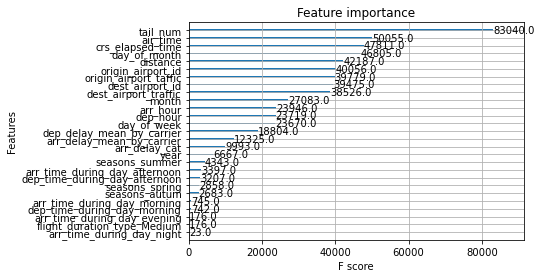

In [128]:
# I use xgboost for feature selection

from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model to training data
xgb_model = XGBClassifier(random_state = 0 )
xgb_model.fit(x_train, y_train)

print("Feature Importances : ", xgb_model.feature_importances_)

# plot feature importance
plot_importance(xgb_model)
plt.show()

### Just select the important features

In [98]:
X_train = x_train[['air_time', 'tail_num','day_of_month','crs_elapsed_time','distance','origin_airport_id','origin_airport_taffic','dest_airport_id','dest_airport_traffic','month', 'day_of_week',
'dep_hour', 'arr_hour','dep_delay_mean_by_carrier', 'arr_delay_mean_by_carrier','year', 'seasons_summer','dep_time_during_day_afternoon',
'arr_time_during_day_afternoon','seasons_autum', 'seasons_spring','arr_time_during_day_morning','dep_time_during_day_morning','arr_time_during_day_evening','flight_duration_type_Medium', 'arr_time_during_day_night']]

In [99]:
X_test = x_test[['air_time', 'tail_num','day_of_month','crs_elapsed_time','distance','origin_airport_id','origin_airport_taffic','dest_airport_id','dest_airport_traffic','month', 'day_of_week',
'dep_hour', 'arr_hour','dep_delay_mean_by_carrier', 'arr_delay_mean_by_carrier','year', 'seasons_summer','dep_time_during_day_afternoon',
'arr_time_during_day_afternoon','seasons_autum', 'seasons_spring','arr_time_during_day_morning','dep_time_during_day_morning','arr_time_during_day_evening','flight_duration_type_Medium', 'arr_time_during_day_night']]

### Modeling

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [102]:
X_test.shape

(367284, 26)

In [103]:
X_train.shape

(122428, 26)

In [104]:
y_test.shape

(367284,)

### Linear Regression

In [109]:
from sklearn import metrics, linear_model #modelling
lm = linear_model.LinearRegression()
model = lm.fit(X_train , y_train)
predictions = pd.DataFrame(lm.predict(X_test))
print(predictions.head(50))
print("MSE =", metrics.mean_squared_error(predictions, y_test))

            0
0    1.252613
1   21.793278
2    1.659208
3  -11.729622
4  -15.046716
5    5.030506
6   30.721645
7   12.100482
8    0.408793
9    0.648893
10  18.263036
11  20.120193
12  -1.096816
13  25.265824
14   6.761619
15  26.496047
16   3.582812
17 -10.791369
18  -4.229342
19   6.283515
20  10.134850
21 -10.958272
22  11.469237
23  14.909371
24  12.322797
25   6.797335
26   4.051495
27   7.306352
28  11.634204
29   9.471409
30   2.833611
31  16.032752
32   9.205960
33   1.898971
34  -2.164722
35 -26.721892
36  -4.492940
37 -10.436845
38   7.259844
39  12.364388
40  17.749931
41   8.943230
42  -4.974175
43   1.198538
44   3.828749
45   9.224963
46  16.340869
47  18.502812
48   2.934990
49  13.115245
MSE = 2373.509315438391


### Polynomial Regression

In [110]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
y_ = poly.fit_transform(X_test)
regr.fit(X_, y_train)

LinearRegression()

In [111]:
result = pd.DataFrame(regr.predict(X_))
print(result.head(50))
print("MSE =", metrics.mean_squared_error(result, y_train))

            0
0   -3.288135
1   14.730502
2    4.670424
3   16.634756
4    5.423369
5    4.702193
6   16.089934
7   12.366726
8   12.043966
9   -3.384431
10  -5.224988
11   4.430281
12  -5.241034
13   4.803016
14  19.629954
15   3.612069
16   8.988906
17  -3.233566
18  15.546644
19  -8.695863
20  -1.012302
21   2.200563
22  -0.054214
23  17.687108
24   2.680720
25  -6.172526
26  14.131613
27   4.795137
28   3.724743
29  56.328415
30  -0.125006
31  13.447074
32   3.080188
33 -23.407600
34  -3.076989
35   5.117185
36  -6.762445
37  21.351105
38   4.051932
39   1.225593
40  20.772004
41  -5.923113
42  10.647569
43   4.725644
44   1.706955
45  17.560420
46   2.696054
47  46.317297
48  13.070456
49  -2.483388
MSE = 2336.556187327034


### Predicting on test data

In [112]:
result_test = pd.DataFrame(regr.predict(y_))
print(result.head(50))
print("MSE =", metrics.mean_squared_error(result_test, y_test))

            0
0   -3.288135
1   14.730502
2    4.670424
3   16.634756
4    5.423369
5    4.702193
6   16.089934
7   12.366726
8   12.043966
9   -3.384431
10  -5.224988
11   4.430281
12  -5.241034
13   4.803016
14  19.629954
15   3.612069
16   8.988906
17  -3.233566
18  15.546644
19  -8.695863
20  -1.012302
21   2.200563
22  -0.054214
23  17.687108
24   2.680720
25  -6.172526
26  14.131613
27   4.795137
28   3.724743
29  56.328415
30  -0.125006
31  13.447074
32   3.080188
33 -23.407600
34  -3.076989
35   5.117185
36  -6.762445
37  21.351105
38   4.051932
39   1.225593
40  20.772004
41  -5.923113
42  10.647569
43   4.725644
44   1.706955
45  17.560420
46   2.696054
47  46.317297
48  13.070456
49  -2.483388
MSE = 3482.6366678963072


Random Forest Regression

In [113]:
#Random Forest Regressors
from sklearn.ensemble import RandomForestRegressor

clf=RandomForestRegressor(n_estimators=40, max_depth=6, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("MSE =", metrics.mean_squared_error(y_pred, y_test))


MSE = 2419.1658003690673


Naive Bayes model

In [114]:
y_cat = df_flights.arr_delay_cat
X_cat = df_flights.drop(['arr_delay_cat'], axis = 1)


In [116]:
x_test_1, x_train_1, y_test_1, y_train_1 = train_test_split(X_cat, y_cat, test_size=0.25, random_state=42)

In [117]:
from sklearn.naive_bayes import GaussianNB

clf=GaussianNB()
clf.fit(x_train_1, y_train_1)
y_pred=clf.predict(x_test_1)

In [ ]:

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_1,y_pred)
cm

array([[230508,   8343],
       [ 33745,  94904]])

In [118]:
from sklearn.metrics import precision_score
precision = precision_score(y_test_1,y_pred)
precision

0.9326544214219905

In [119]:
from sklearn.metrics import recall_score
recall = recall_score(y_test_1, y_pred)
print('Recall: %.3f' % recall)

Recall: 0.739


In [120]:
from sklearn.metrics import f1_score
score = f1_score(y_test_1, y_pred)
print('F-Measure: %.3f' % score)

F-Measure: 0.824


# SVM

In [121]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

svm = SVC(kernel='rbf', C=1000, gamma=6, random_state=47).fit(x_train_1, y_train_1)
ypred = svm.predict(x_test_1)

print('Recall: {:.3f}'.format(recall_score(y_test_1, ypred)))
print('Precision: {:.3f}'.format(precision_score(y_test_1, y_pred)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, ypred)))
print('F1: {:.3f}'.format(f1_score(y_test_1, y_pred)))
confusion = confusion_matrix(y_test_1, y_pred)
print(confusion)

#y_scores = svm.decision_function(X_test_scaled)
#y_score_list = list(zip(y_test[0:20], y_scores[0:20]))

Recall: 0.000
Precision: 0.933
Accuracy: 0.019
F1: 0.824
[[231578   6871]
 [ 33680  95155]]


### XGBOOST Regressor

In [124]:
from xgboost import XGBRegressor
model = XGBRegressor()

/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [125]:
#Train the model
model.fit(X_train,y_train )

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [127]:

ypred=model.predict(X_test)
print("MSE =", metrics.mean_squared_error(ypred, y_test))

MSE = 2415.325948684364
